In [1]:
# Neural TO in 100 lines of code [JAX]

# MBB beam BC
# NN - from Keras
# sigmoid + bisection - from scratch
# Convoluion as filter
# FEA - from 88 lines code
# calculate compliance
# Use adam optimizer
# select free dofs and solve system
# https://github.com/google/jax/discussions/16291 
# https://github.com/google/jax/discussions/16248
# https://github.com/google/jax/issues/22500
# https://github.com/patrick-kidger/lineax/issues/24
# https://github.com/google/jax/issues/13118

In [1]:
try:
    import jax
    import jax.numpy as jnp
    jax.config.update("jax_enable_x64", True)
    import os
    os.environ["KERAS_BACKEND"] = "jax"
    from keras import layers
    import keras
except:
    print("JAX not installed")

JAX not installed


In [2]:
# discretization
Nx = 3
Ny = 2
volfrac = 0.5   # Volume fraction
maxit = 75
E0 = 1.0
nu = 0.3
E_min = 1e-9
rmin=2
penal = 3 

In [3]:
# FEA - top71
A11 = jnp.array([[12, 3, -6, -3], [3, 12, 3, 0], [-6, 3, 12, -3], [-3, 0, -3, 12]])
A12 = jnp.array([[-6, -3, 0, 3], [-3, -6, -3, -6], [0, -3, -6, 3], [3, -6, 3, -6]])
B11 = jnp.array([[-4, 3, -2, 9], [3, -4, -9, 4], [-2, -9, -4, -3], [9, 4, -3, -4]])
B12 = jnp.array([[2, -3, 4, -9], [-3, 2, 9, -2], [4, 9, 2, 3], [-9, -2, 3, 2]])
KE = 1/(1-nu**2)/24 * (jnp.block([[A11, A12], [A12.T, A11]]) + nu* jnp.block([[B11, B12], [B12.T, B11]]))
nodeNrs = jnp.arange((1 + Nx) * (1 + Ny)).reshape((1 + Ny), (1 + Nx), order='F')
cVec = (nodeNrs[0:-1, 0:-1]*2 + 2).reshape(Nx*Ny, 1, order='F').ravel()
offsets = jax.numpy.array([0, 1, 2*Ny + 2, 2*Ny + 3, 2*Ny, 2*Ny + 1, -2, -1])
cMat = cVec[:, None] + offsets
iK = jnp.kron(cMat, jnp.ones((8, 1), dtype=jnp.int32)).T.ravel(order='F')
jK = jnp.kron(cMat, jnp.ones((1, 8), dtype=jnp.int32)).ravel()
Iar = jnp.concatenate([iK.reshape(-1,1), jK.reshape(-1,1)], axis=1)

# MBB beam BC
nDof = 2 * (Nx + 1) * (Ny + 1)
lcDof = 1 # 2*nodeNrs[0, 0] - 1
fixed1 = jnp.arange(0, 2 * (Ny + 1), 2) # left edge along x axis
fixed2 = 2 * nodeNrs[-1, -1] + 1 # bottom right corner, along y axis
fixed = jnp.union1d(fixed1, fixed2)
F = jnp.zeros(nDof)
F = F.at[lcDof].set(-1)
F = F.at[fixed].set(0.0)
free = jnp.setdiff1d(jnp.arange(nDof), fixed)

# Convoluion as filter
range_of_val = jnp.arange(-jnp.ceil(rmin) + 1, jnp.ceil(rmin))
dx, dy = jnp.meshgrid(range_of_val, range_of_val)
h = jnp.maximum(0, rmin - jnp.sqrt(dx**2 + dy**2)) # Cone filter (2D)
Hs = jax.scipy.signal.convolve(jnp.ones((Ny, Nx)), h, mode='same') # Assuming dirichlet BC in matlab code

In [4]:
cMat

Array([[ 2,  3,  8,  9,  6,  7,  0,  1],
       [ 4,  5, 10, 11,  8,  9,  2,  3],
       [ 8,  9, 14, 15, 12, 13,  6,  7],
       [10, 11, 16, 17, 14, 15,  8,  9],
       [14, 15, 20, 21, 18, 19, 12, 13],
       [16, 17, 22, 23, 20, 21, 14, 15]], dtype=int64)

In [7]:
# Regular TO pipeline
from functools import partial
from jax.experimental import sparse
import optimistix as optx

fixed_set = jnp.array(fixed)
is_fixed_0 = jnp.isin(Iar[:, 0], fixed_set)
is_fixed_1 = jnp.isin(Iar[:, 1], fixed_set) 
is_diag = Iar[:, 0] == Iar[:, 1]
diag_mask = is_fixed_0 & is_diag
offdiag_mask = is_fixed_0 | is_fixed_1
offdiag_inds = offdiag_mask & ~is_diag

# @partial(jax.jit)
@jax.custom_vjp
def find_comp(x, F):
    xTilde = jnp.true_divide(jax.scipy.signal.convolve(x.reshape((Ny, Nx), order='F'), h, mode='same'), Hs).ravel(order='F')
    sK = E_min + xTilde**penal * (E0 - E_min)
    sK =(KE.reshape(-1, 1) * sK.reshape(1, -1)).ravel(order='F')
    sK = sK.at[diag_mask].set(1.0)
    sK = sK.at[offdiag_inds].set(0.0)
    K = jax.experimental.sparse.BCOO((sK, Iar), shape=(2 * (Nx + 1) * (Ny + 1), 2 * (Nx + 1) * (Ny + 1)))
    K = ((K + K.T) / 2.0).sum_duplicates(nse=len(Iar))
    K_bcsr = sparse.BCSR.from_bcoo(K)
    sol = sparse.linalg.spsolve(K_bcsr.data, K_bcsr.indices.astype(jnp.int32), K_bcsr.indptr, F, tol=1e-06, reorder=1)
    ce = jnp.sum((sol[cMat]@KE) * sol[cMat], axis=1).reshape(Ny, Nx, order='F')
    c_value = ((E_min + xTilde**penal * (E0 - E_min)).reshape(Ny, Nx, order='F') * ce).sum()
    # c_value = jnp.dot(sol, F)
    return c_value, xTilde, ce

def find_comp_fwd(x, F):
    c_value, xTilde, ce = find_comp(x, F)
    return (c_value, xTilde), (xTilde, ce)

def find_comp_bwd(res, g):
    xPhys, ce = res
    dc = -penal*(E0-E_min)*xPhys.reshape(Ny, Nx, order='F')**(penal-1)*ce#).ravel(order='F')  
    dc = jax.scipy.signal.convolve(jnp.true_divide(dc, Hs), h, mode='same').ravel(order='F')
    return dc.reshape(-1, 1)*g[0], jnp.zeros_like(F)

find_comp.defvjp(find_comp_fwd, find_comp_bwd)

In [8]:
x = jnp.ones(Nx * Ny) * volfrac
xTilde = jnp.true_divide(jax.scipy.signal.convolve(x.reshape((Ny, Nx), order='F'), h, mode='same'), Hs).ravel(order='F')
sK = E_min + xTilde**penal * (E0 - E_min)
sK =(KE.reshape(-1, 1) * sK.reshape(1, -1)).ravel(order='F')
sK = sK.at[diag_mask].set(1.0)
sK = sK.at[offdiag_inds].set(0.0)
K = jax.experimental.sparse.BCOO((sK, Iar), shape=(2 * (Nx + 1) * (Ny + 1), 2 * (Nx + 1) * (Ny + 1)))
K = ((K + K.T) / 2.0).sum_duplicates(nse=len(Iar))
K_bcsr = sparse.BCSR.from_bcoo(K)

In [13]:
K.todense()



Array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.06181319,  0.        , -0.03777473, -0.00171703,
         0.00686813,  0.02232143, -0.03090659,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.03777473,  0.        ,  0.06181319, -0.02232143,
        -0.03090659,  0.00171703,  0.00686813,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00171703,  0.        , -0.02232143,  0.12362637,
         0.        ,  0.01373626,  0.        , -0.03777473,  0.00171703,
        -0.03090659,  0.        ],
       [ 0.        ,  0.00686813,  0.        , -0.03090659,  0.        ,
         0.12362637,  

# Neural models and optimizers

In [5]:
root_solver = optx.Bisection(rtol=1e-10, atol=1e-10) #optx.Newton(rtol=1e-8, atol=1e-8)

class EnforceVolumeLayer(layers.Layer):
    def __init__(self, volfrac):
        super().__init__()
        self.volfrac = volfrac

    def call(self, x):
        root_fn = lambda b, xTilde: jax.nn.sigmoid(b + xTilde).mean() - self.volfrac
        b_opt = optx.root_find(root_fn, root_solver, 0.0, x, options=dict(lower=-100, upper=100)).value
        return jax.nn.sigmoid(b_opt + x)

In [6]:
# old
def sine_init(shape, dtype=None, omega=30.0, seed=0, first=False):
    limit = keras.ops.sqrt(6 / shape[0]) / omega
    if first:
        limit = 1 / shape[0]
    return keras.random.uniform(shape, minval=-limit, maxval=limit, seed=seed)

def get_siren_model(num_layers, units, omega0=30.0, seed=0):
    first_init = partial(sine_init, seed=seed, first=True)
    hidden_init = partial(sine_init, seed=seed, omega=omega0)
    x = inputs = keras.Input(shape=(2,))
    x = keras.ops.sin(layers.Dense(units, kernel_initializer=first_init)(x) * omega0)
    for _ in range(num_layers-1):
        x = keras.ops.sin(layers.Dense(units, kernel_initializer=hidden_init)(x) * omega0)
    x = layers.Dense(1, kernel_initializer=hidden_init)(x)
    outputs = EnforceVolumeLayer(volfrac)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def get_mlp_model(units, num_layers):
    x = inputs = keras.Input(shape=(2,))
    for _ in range(num_layers):
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(1)(x)
    outputs = EnforceVolumeLayer(volfrac)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def get_cnn_model(latent_size, Nx, Ny):
    net = inputs = keras.Input(shape=(latent_size,), name="inp")
    filters = (Ny//8) * (Nx//8) * 32
    net = keras.layers.Dense(filters, kernel_initializer=keras.initializers.orthogonal(
        keras.ops.sqrt(max(filters / latent_size, 1))))(net)
    net = keras.layers.Reshape([Ny//8, Nx//8, 32])(net)
    for resize, filter in zip((1, 2, 2, 2, 1), (64, 32, 16, 8, 1)):
        net = keras.layers.Activation("tanh")(net)
        net = keras.layers.UpSampling2D((resize, resize), interpolation='bilinear')(net)
        net = keras.layers.LayerNormalization()(net)
        net = keras.layers.Conv2D(
            filter, (5, 5), kernel_initializer=keras.initializers.VarianceScaling, padding="same")(net)
    x = keras.layers.Reshape([Ny, Nx])(keras.layers.Flatten()(net))
    outputs = EnforceVolumeLayer(volfrac)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
# New
def sine_init(shape, dtype=None, omega=30.0, seed=0, first=False):
    limit = 1 / shape[0] if first else keras.ops.sqrt(6 / shape[0]) / omega
    return keras.random.uniform(shape, minval=-limit, maxval=limit, seed=seed)

def get_siren_model(num_layers, units, omega0=30.0, seed=0):
    dense_layer = lambda init, x: keras.ops.sin(layers.Dense(units, kernel_initializer=init)(x) * omega0)
    first_init = partial(sine_init, seed=seed, first=True)
    hidden_init = partial(sine_init, seed=seed, omega=omega0)

    x = inputs = keras.Input(shape=(2,))
    x = dense_layer(first_init, x)
    for _ in range(num_layers-1):
        x = dense_layer(hidden_init, x)
    x = layers.Dense(1, kernel_initializer=hidden_init)(x)
    outputs = EnforceVolumeLayer(volfrac)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

def get_mlp_model(units, num_layers):
    x = inputs = keras.Input(shape=(2,))
    for _ in range(num_layers):
        x = layers.Dense(units, activation="relu")(x)
        x = layers.BatchNormalization()(x)
    outputs = EnforceVolumeLayer(volfrac)(layers.Dense(1)(x))
    return keras.Model(inputs=inputs, outputs=outputs)

def get_cnn_model(latent_size, Nx, Ny):
    def conv_block(net, resize, filters):
        net = keras.layers.UpSampling2D((resize, resize), interpolation='bilinear')(keras.layers.Activation("tanh")(net))
        return keras.layers.Conv2D(filters, (5, 5), padding="same")(keras.layers.LayerNormalization()(net))

    filters = (Ny // 8) * (Nx // 8) * 32
    net = inputs = keras.Input(shape=(latent_size,))
    net = keras.layers.Dense(filters, kernel_initializer=keras.initializers.orthogonal(
        keras.ops.sqrt(max(filters / latent_size, 1))))(net)
    net = keras.layers.Reshape([Ny // 8, Nx // 8, 32])(net)

    for resize, filter in zip((1, 2, 2, 2, 1), (64, 32, 16, 8, 1)):
        net = conv_block(net, resize, filter)
    
    x = keras.layers.Reshape([Ny, Nx])(keras.layers.Flatten()(net))
    outputs = EnforceVolumeLayer(volfrac)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


In [8]:
model = get_cnn_model(10, Nx, Ny) #Siren(50, 3, 1, omega_0=100)#get_model(
_ = model(jnp.ones((3, 10)))
optimizer = keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1e-2)
optimizer.build(model.trainable_variables)

In [9]:
# for cnn 
x = jnp.ones((1, 10))
train_vars = model.trainable_variables
non_train_vars = model.non_trainable_variables

def compute_loss_updates(train_vars, non_train_vars, x):
    output, non_train_vars = model.stateless_call(train_vars, non_train_vars, x)
    c, design = find_comp(output.reshape(-1, 1, order='F'), F)
    return c, (non_train_vars, design)

grad_fn = jax.value_and_grad(compute_loss_updates, has_aux=True)

@jax.jit
def train(state, x):
    train_vars, non_train_vars, opt_vars, _ = state
    (loss, (non_train_vars, design)), grad = grad_fn(train_vars, non_train_vars, x)
    train_vars, opt_vars = optimizer.stateless_apply(opt_vars, grad, train_vars)
    return loss, (train_vars, non_train_vars, opt_vars, design)

state = ([w.value for w in train_vars], non_train_vars, optimizer.variables, None)
for i in range(maxit):
    loss, state = train(state, x)
    print(f"Iteration: {i}, Loss: {loss}")

Iteration: 0, Loss: 3645.8521838725583
Iteration: 1, Loss: 1156.509568038741
Iteration: 2, Loss: 689.1192198859746
Iteration: 3, Loss: 506.05865411793144
Iteration: 4, Loss: 389.67617546186545
Iteration: 5, Loss: 315.02134047345055
Iteration: 6, Loss: 268.3876600712308
Iteration: 7, Loss: 234.3679877613078
Iteration: 8, Loss: 208.42679599542907
Iteration: 9, Loss: 187.2744682104289
Iteration: 10, Loss: 168.59279965615985
Iteration: 11, Loss: 152.12821328602763
Iteration: 12, Loss: 137.9967110738259
Iteration: 13, Loss: 126.15800794834317
Iteration: 14, Loss: 116.40933000888919
Iteration: 15, Loss: 108.32760808638784
Iteration: 16, Loss: 101.43561740262167
Iteration: 17, Loss: 95.48549746423811
Iteration: 18, Loss: 90.45252156874002
Iteration: 19, Loss: 86.29023177573855
Iteration: 20, Loss: 82.79135717966787
Iteration: 21, Loss: 79.70512159837207
Iteration: 22, Loss: 76.88546850475596
Iteration: 23, Loss: 74.29979534954127
Iteration: 24, Loss: 71.93177404949162
Iteration: 25, Loss: 69.

In [95]:
# get network input (nEl, 2)
# Create a grid of center coordinates
x_centers = jnp.linspace(-1 + 1/Nx, 1 - 1/Nx, Nx)
y_centers = jnp.linspace(-1 + 1/Ny, 1 - 1/Ny, Ny)

# Create a meshgrid from x and y centers
x_grid, y_grid = jnp.meshgrid(x_centers, y_centers, indexing='ij')

# Stack the grid coordinates into a single array of shape (Nx * Ny, 2)
x = jnp.column_stack([x_grid.ravel(), jnp.flip(y_grid).ravel()])

train_vars = model.trainable_variables
non_train_vars = model.non_trainable_variables

def compute_loss_updates(train_vars, non_train_vars, x):
    output, non_train_vars = model.stateless_call(train_vars, non_train_vars, x)
    c, design = find_comp(output, F)
    return c, (non_train_vars, design)

grad_fn = jax.value_and_grad(compute_loss_updates, has_aux=True)

@jax.jit
def train(state, x):
    train_vars, non_train_vars, opt_vars, _ = state
    (loss, (non_train_vars, design)), grad = grad_fn(train_vars, non_train_vars, x)
    train_vars, opt_vars = optimizer.stateless_apply(opt_vars, grad, train_vars)
    return loss, (train_vars, non_train_vars, opt_vars, design)

state = ([w.value for w in train_vars], non_train_vars, optimizer.variables, None)

Iteration: 0, Loss: 1887.1529444283115
Iteration: 1, Loss: 963.465929901738
Iteration: 2, Loss: 637.2813199689981
Iteration: 3, Loss: 466.6914633898561
Iteration: 4, Loss: 370.1885323720079
Iteration: 5, Loss: 311.74368493501555
Iteration: 6, Loss: 274.9968351924058
Iteration: 7, Loss: 249.06418671611775
Iteration: 8, Loss: 227.6089865494722
Iteration: 9, Loss: 209.10327593704585
Iteration: 10, Loss: 193.34800014974974
Iteration: 11, Loss: 179.79700418208625
Iteration: 12, Loss: 168.02203391547093
Iteration: 13, Loss: 157.5612044555362
Iteration: 14, Loss: 148.2211894000748
Iteration: 15, Loss: 139.78693416531002
Iteration: 16, Loss: 131.96705428543623
Iteration: 17, Loss: 124.66474034700838
Iteration: 18, Loss: 117.93963753129135
Iteration: 19, Loss: 111.88095242059694
Iteration: 20, Loss: 106.49124224426184
Iteration: 21, Loss: 101.66830534763663
Iteration: 22, Loss: 97.30355913239134
Iteration: 23, Loss: 93.34673290154056
Iteration: 24, Loss: 89.76023944201731
Iteration: 25, Loss: 8

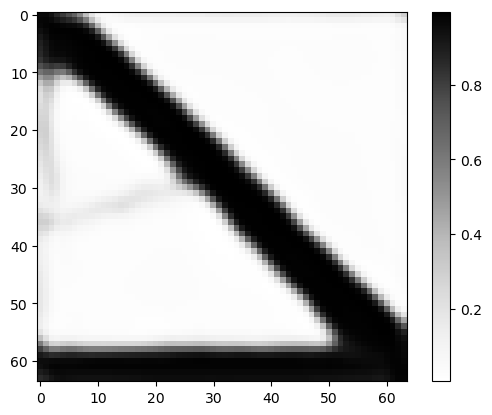

In [102]:
for i in range(maxit):
    loss, state = train(state, x)
    print(f"Iteration: {i}, Loss: {loss}")

des = state[-1].reshape((Ny, Nx), order='F')
import matplotlib.pyplot as plt
plt.imshow(des, cmap='Greys')
plt.colorbar()

In [22]:
# check gradients
from jax.test_util import check_grads

def loss_fn(x):
    return find_comp(x, F)[0]

check_grads(loss_fn, (jax.random.uniform(jax.random.PRNGKey(2), (Ny*Nx, 1)),), order=1, modes=['rev'])


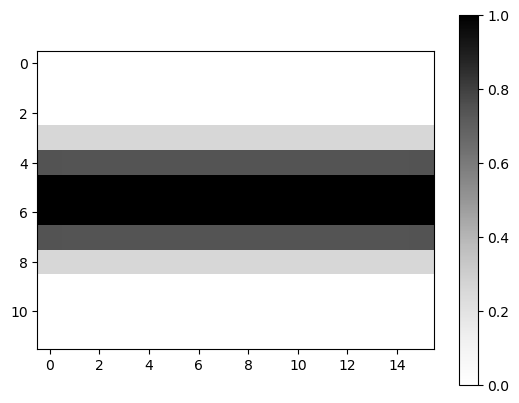

In [201]:
# Check filter 
# Create a black square [with values 1] and set everything else to 0
# Try th convolution filter on it
# Check visually if the filter is working as expected

import matplotlib.pyplot as plt
nx = 16
ny = 12
init_design = jnp.zeros((nx*ny, 1))
# make a black square along the x direction at the center
init_design_reshaped = init_design.reshape(ny, nx, order='F')
init_design_reshaped = init_design_reshaped.at[ny//2-2:ny//2+2, :].set(1).ravel(order='F')
plt.imshow(init_design_reshaped.reshape(ny, nx, order='F'), cmap='Greys')
plt.colorbar()
# # Apply the filter
Hs = jax.scipy.signal.convolve(jnp.ones((ny, nx)), h, mode='same') # Assuming dirichlet BC in matlab code
xTilde = jnp.true_divide(jax.scipy.signal.convolve(init_design_reshaped.reshape((ny, nx), order='F'), h, mode='same'), Hs).ravel(order='F')
# show the filtered image
plt.imshow(xTilde.reshape(ny, nx, order='F'), cmap='Greys')    

In [ ]:
# Imports
import os, jax, jax.numpy as jnp, matplotlib.pyplot as plt
from jax.experimental import sparse
import keras, optimistix as optx
from functools import partial
from keras import layers

# Setup
os.environ["KERAS_BACKEND"] = "jax"
jax.config.update("jax_enable_x64", True)
Nx, Ny, volfrac, maxit = 64, 64, 0.3, 100
E0, nu, E_min, rmin, penal = 1.0, 0.3, 1e-9, 2, 3
A11 = jnp.array([[12, 3, -6, -3], [3, 12, 3, 0], [-6, 3, 12, -3], [-3, 0, -3, 12]])
A12 = jnp.array([[-6, -3, 0, 3], [-3, -6, -3, -6], [0, -3, -6, 3], [3, -6, 3, -6]])
B11 = jnp.array([[-4, 3, -2, 9], [3, -4, -9, 4], [-2, -9, -4, -3], [9, 4, -3, -4]])
B12 = jnp.array([[2, -3, 4, -9], [-3, 2, 9, -2], [4, 9, 2, 3], [-9, -2, 3, 2]])
KE = (1/(1-nu**2)/24 * (jnp.block([[A11, A12], [A12.T, A11]]) + nu * jnp.block([[B11, B12], [B12.T, B11]])))
nodeNrs = jnp.arange((1 + Nx) * (1 + Ny)).reshape((1 + Ny), (1 + Nx), order='F')
cVec, offsets = (nodeNrs[:-1, :-1]*2 + 2).reshape(Nx*Ny, 1, order='F').ravel(), jnp.array([0, 1, 2*Ny + 2, 2*Ny + 3, 2*Ny, 2*Ny + 1, -2, -1])
cMat, Iar = cVec[:, None] + offsets, jnp.concatenate([jnp.kron(cVec[:, None] + offsets, jnp.ones((8, 1), dtype=jnp.int32)).T.ravel(order='F').reshape(-1, 1), jnp.kron(cVec[:, None] + offsets, jnp.ones((1, 8), dtype=jnp.int32)).ravel().reshape(-1, 1)], axis=1)
nDof, lcDof = 2 * (Nx + 1) * (Ny + 1), 1
fixed = jnp.union1d(jnp.arange(0, 2 * (Ny + 1), 2), 2 * nodeNrs[-1, -1] + 1)
F, free = jnp.zeros(nDof).at[lcDof].set(-1).at[fixed].set(0.0), jnp.setdiff1d(jnp.arange(nDof), fixed)
dx, dy = jnp.meshgrid(jnp.arange(-jnp.ceil(rmin) + 1, jnp.ceil(rmin)), jnp.arange(-jnp.ceil(rmin) + 1, jnp.ceil(rmin)))
h, Hs = jnp.maximum(0, rmin - jnp.sqrt(dx**2 + dy**2)), jax.scipy.signal.convolve(jnp.ones((Ny, Nx)), h, mode='same')
is_fixed_0, is_fixed_1 = jnp.isin(Iar[:, 0], jnp.array(fixed)), jnp.isin(Iar[:, 1], jnp.array(fixed))
diag_mask, offdiag_inds = is_fixed_0 & (Iar[:, 0] == Iar[:, 1]), (is_fixed_0 | is_fixed_1) & ~(Iar[:, 0] == Iar[:, 1])

# Black-box calculation of compliance
@jax.custom_vjp
def find_comp(x, F):
    xTilde = jax.scipy.signal.convolve(x.reshape((Ny, Nx), order='F'), h, mode='same').ravel(order='F') / Hs
    sK = (KE.reshape(-1, 1) * (E_min + xTilde**penal * (E0 - E_min)).reshape(1, -1)).ravel(order='F').at[diag_mask].set(1.0).at[offdiag_inds].set(0.0)
    K = sparse.BCOO((sK, Iar), shape=(2*(Nx+1)*(Ny+1), 2*(Nx+1)*(Ny+1))).sum_duplicates(nse=len(Iar))
    sol = sparse.linalg.spsolve(sparse.BCSR.from_bcoo(K).data, K.indices.astype(jnp.int32), K.indptr, F, tol=1e-06, reorder=1)
    ce, c_value = jnp.sum((sol[cMat]@KE) * sol[cMat], axis=1).reshape(Ny, Nx, order='F'), jnp.sum((E_min + xTilde**penal * (E0 - E_min)).reshape(Ny, Nx, order='F') * ce)
    return c_value, xTilde, ce

def find_comp_fwd(x, F): c_value, xTilde, ce = find_comp(x, F); return (c_value, xTilde), (xTilde, ce)
def find_comp_bwd(res, g): return (-penal*(E0-E_min)*res[0].reshape(Ny, Nx, order='F')**(penal-1)*res[1]).ravel(order='F') / Hs * g[0], jnp.zeros_like(F)
find_comp.defvjp(find_comp_fwd, find_comp_bwd)

# Neural network models
root_solver = optx.Bisection(rtol=1e-10, atol=1e-10)
class EnforceVolumeLayer(layers.Layer):
    def __init__(self, volfrac): super().__init__(); self.volfrac = volfrac
    def call(self, x): return jax.nn.sigmoid(optx.root_find(lambda b, xTilde: jax.nn.sigmoid(b + xTilde).mean() - self.volfrac, root_solver, 0.0, x, options=dict(lower=-100, upper=100)).value + x)

def sine_init(shape, dtype=None, omega=30.0, seed=0, first=False): limit = 1/shape[0] if first else keras.ops.sqrt(6/shape[0])/omega; return keras.random.uniform(shape, minval=-limit, maxval=limit, seed=seed)

def get_model(model_type, num_layers, units, latent_size=10):
    def dense_layer(init, x): return keras.ops.sin(layers.Dense(units, kernel_initializer=init)(x) * omega0)
    if model_type == 'siren':
        first_init, hidden_init, omega0 = partial(sine_init, seed=0, first=True), partial(sine_init, seed=0, omega=30.0), 30.0
        x = inputs = keras.Input(shape=(2,))
        x = dense_layer(first_init, x)
        for _ in range(num_layers - 1): x = dense_layer(hidden_init, x)
        x = layers.Dense(1, kernel_initializer=hidden_init)(x)
    elif model_type == 'mlp':
        x = inputs = keras.Input(shape=(2,))
        for _ in range(num_layers): x = layers.Dense(units, activation="relu")(x); x = layers.BatchNormalization()(x)
        x = layers.Dense(1)(x)
    elif model_type == 'cnn':
        def conv_block(net, resize, filters): return keras.layers.Conv2D(filters, (5, 5), padding="same")(keras.layers.LayerNormalization()(keras.layers.UpSampling2D((resize, resize), interpolation='bilinear')(keras.layers.Activation("tanh")(net))))
        filters, x = (Ny // 8) * (Nx // 8) * 32, inputs = keras.Input(shape=(latent_size,))
        net = keras.layers.Reshape([Ny // 8, Nx // 8, 32])(keras.layers.Dense(filters, kernel_initializer=keras.initializers.orthogonal(keras.ops.sqrt(max(filters / latent_size, 1))))(x))
        for resize, filter in zip((1, 2, 2, 2, 1), (64, 32, 16, 8, 1)): net = conv_block(net, resize, filter)
        x = keras.layers.Reshape([Ny, Nx])(keras.layers.Flatten()(net))
    outputs = EnforceVolumeLayer(volfrac)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

# Optimization
model = get_model('cnn', 0, 0, 10)  # Choose 'siren', 'mlp', or 'cnn' with parameters
_ = model(jnp.ones((3, 10)))  # Initialize the model
optimizer = keras.optimizers.Adam(learning_rate=1e-2, clipnorm=1e-2)
optimizer.build(model.trainable_variables)
state = ([w.value for w in model.trainable_variables], model.non_trainable_variables, optimizer.variables, None)
train_vars, non_train_vars = model.trainable_variables, model.non_trainable_variables

def compute_loss_updates(train_vars, non_train_vars, x):
    output, non_train_vars = model.stateless_call(train_vars, non_train_vars, x)
    c, design = find_comp(output.reshape(-1, 1, order='F'), F)
    return c, (non_train_vars, design)

grad_fn = jax.value_and_grad(compute_loss_updates, has_aux=True)

@jax.jit
def train(state, x):
    train_vars, non_train_vars, opt_vars, _ = state
    (loss, (non_train_vars, design)), grad = grad_fn(train_vars, non_train_vars, x)
    train_vars, opt_vars = optimizer.stateless_apply(opt_vars, grad, train_vars)
    return loss, (train_vars, non_train_vars, opt_vars, design)

for i in range(maxit):
    loss, state = train(state, jnp.ones((1, 10)))
    print(f"Iteration: {i}, Loss: {loss}")

# Display result
plt.imshow(state[-1].reshape((Ny, Nx), order='F'), cmap='Greys')
plt.colorbar()


# Implicit function theorem

In [23]:
import jax 
import jax.numpy as jnp
from functools import partial

# @jax.custom_vjp(nondiff_argnums=(0,2,3,4,5))
@partial(jax.custom_vjp, nondiff_argnums=(0,2,3,4,5))
def custom_bisection_alg(root_fn, net_out, lb, ub, max_iter=100, tol=1e-10):
    for _ in range(max_iter):
        mid = (lb + ub) / 2
        mid_val = root_fn(mid, net_out)
        if mid_val > 0:
            ub = mid
        else:
            lb = mid
        if jnp.abs(mid_val) < tol:
            break
    return mid

def custom_bisection_alg_fwd(root_fn, net_out, lb, ub, max_iter=100, tol=1e-10):
    b_opt = custom_bisection_alg(root_fn, net_out, lb, ub, max_iter, tol)
    res = net_out, b_opt
    return b_opt, res

def custom_bisection_alg_bwd(root_fn, lb, ub, max_iter, tol, res, g):
    design, b_opt = res
    df_db, df_ddes = jax.grad(root_fn, (0, 1))(b_opt, design)
    vJP = -g*df_ddes / df_db
    return (vJP.reshape(design.shape), )

custom_bisection_alg.defvjp(custom_bisection_alg_fwd, custom_bisection_alg_bwd) 

# Test
def root_fn(b, design):
    return jax.nn.sigmoid(b + design).mean() - volfrac


volfrac = 0.4
Nx= Ny = 10

design = jax.random.uniform(jax.random.PRNGKey(0), (Nx*Ny, 1))
# b = jax.jit(custom_bisection_alg, static_argnums=(0,2,3,4,5))(root_fn, design, -100, 100)
# jax.jacobian(lambda des: custom_bisection_alg(root_fn, des, -100, 100), 0)(design)

In [24]:
jax.grad(lambda des: custom_bisection_alg(root_fn, des, -100, 100), 0)(design)

Array([[-0.00866813],
       [-0.01058955],
       [-0.01056763],
       [-0.01014607],
       [-0.00919227],
       [-0.01056041],
       [-0.01014276],
       [-0.0097378 ],
       [-0.01012735],
       [-0.00970594],
       [-0.00897526],
       [-0.008963  ],
       [-0.01058248],
       [-0.01055084],
       [-0.00971596],
       [-0.01058069],
       [-0.00943302],
       [-0.00933133],
       [-0.00866977],
       [-0.01024209],
       [-0.0095407 ],
       [-0.01060871],
       [-0.01033217],
       [-0.01050381],
       [-0.0101674 ],
       [-0.01039877],
       [-0.00990289],
       [-0.0094158 ],
       [-0.01051008],
       [-0.00871122],
       [-0.01058877],
       [-0.00867018],
       [-0.01005409],
       [-0.01049171],
       [-0.00974384],
       [-0.01035709],
       [-0.01032987],
       [-0.00882012],
       [-0.01056494],
       [-0.00932875],
       [-0.0103867 ],
       [-0.00967012],
       [-0.010227  ],
       [-0.01060135],
       [-0.0106076 ],
       [-0